In [246]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
from rlway.pyosrd.osrd import OSRD

In [248]:
sim = OSRD(use_case='cvg_dvg', dir='tmp')

[17:41:23,638] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[17:41:23,672] [INFO]              [FullInfra] parsing infra
[17:41:23,739] [INFO]              [FullInfra] adaptation to kotlin
[17:41:23,773] [INFO]              [FullInfra] loading signals
[17:41:23,779] [INFO]              [FullInfra] building blocks
[17:41:23,784] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/simulation.json
[17:41:23,799] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.20
[17:41:23,846] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.21
[17:41:23,852] [INFO]  [StandaloneSimulationCommand] All simulations completed
[17:41:23,852] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/results.json


In [249]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def tvds(self) -> list[list[str]]:
    tvds = []
    for route in self.infra['routes']:
        limit_tvds = []
        limit_tvds.append(route['entry_point']['id'])
        for d in route['release_detectors']:
            limit_tvds.append(d)
        limit_tvds.append(route['exit_point']['id'])
        tvds += [
            set([limit_tvds[i], limit_tvds[i+1]]) for i,_  in enumerate(limit_tvds[:-1])
        ]
    
    unique_tvds = []
    for tvd in tvds:
        if tvd not in unique_tvds:
            unique_tvds.append((tvd))

    return unique_tvds

In [250]:
def tvd_blocks(self) -> dict[str, str]:
    tvd_blocks = {
        "<->".join(sorted(d)): "<->".join(sorted(d))
        for d in tvds(self)
    }

    for switch in self.infra['switches']:
        detectors = []
        for port in switch['ports'].values():
            idx = 0 if port['endpoint'] == 'BEGIN' else -1
            detectors_on_track = [
                p.id for p in self.points_on_track_sections[port['track']]
                if p.type=='detector'
            ]
            detectors.append(detectors_on_track[idx])
        
        for a in combinations(detectors, 2):
            if set(a) in tvds(self):
                tvd_blocks["<->".join(sorted(a))] = switch['id']

    return tvd_blocks


In [251]:
def schedule_df_from_OSRD(
    case: OSRD,
    eco_or_base: str = 'base',
) -> pd.DataFrame:

    df = pd.DataFrame(
        columns=pd.MultiIndex.from_product(
            [range(case.num_trains), ['s', 'e']]
        ),
        index=["<->".join(sorted(tvd)) for tvd in tvds(case)]
    )
    df.insert(0, 'block', tvd_blocks(case).values())

    for train, _ in enumerate(case.trains):
        
        tvds_limits = []
        for track in case.train_track_sections(train):
            elements = [
                p.id
                for p in case.points_on_track_sections[track['id']]
                if p.type in ['buffer_stop', 'detector']
            ]
            tvds_limits += (
                elements[::-1]
                if track['direction'] == 'STOP_TO_START'
                else elements
            )

        arrival_time = \
            case.points_encountered_by_train(train, types='arrival')[0][f't_{eco_or_base}']
        detectors = case.points_encountered_by_train(train, types='detector')
        first_detector = detectors[0]['id']
        last_detector = detectors[-1]['id']
        idx_first = tvds_limits.index(first_detector)
        idx_last = tvds_limits.index(last_detector)

        limits = tvds_limits[idx_first-1:idx_last+1]

        for i, _ in enumerate(limits):
            start = tvds_limits[i]
            end = tvds_limits[i+1]
            t_start = (
                case.departure_times[train] if i==0
                else [d[f't_{eco_or_base}'] for d in detectors if d['id']==start][0]
            )
            t_end = (
                arrival_time
                if i==len(limits)-1
                else [d[f't_tail_{eco_or_base}'] for d in detectors if d['id']==end][0]
            )
            df.loc[df.block==tvd_blocks(case)["<->".join(sorted([start, end]))], train] =\
                (t_start, t_end)

    df.set_index('block', inplace=True, drop=True)
    df.drop_duplicates(inplace=True)
    df.index.name=None
    df.columns=pd.MultiIndex.from_product(
            [range(case.num_trains), ['s', 'e']]
        )
    return df

In [252]:
df = schedule_df_from_OSRD(sim)
display(df)

0                       1            
                            s           e           s           e
D0<->buffer_stop.0        0.0   49.271387         NaN         NaN
CVG                 25.290046   53.626722  125.290046  153.626722
D2<->D3             32.871583   96.466092  132.871583  197.099453
D1<->buffer_stop.1        NaN         NaN       100.0  149.271387
DVG                 73.617113  108.066092  173.658637   209.36612
D4<->buffer_stop.2  78.205627  121.066092         NaN         NaN
D5<->buffer_stop.3        NaN         NaN  178.304105  220.699453

<Axes: title={'center': 'train0 (base)'}, xlabel='Time [min]'>

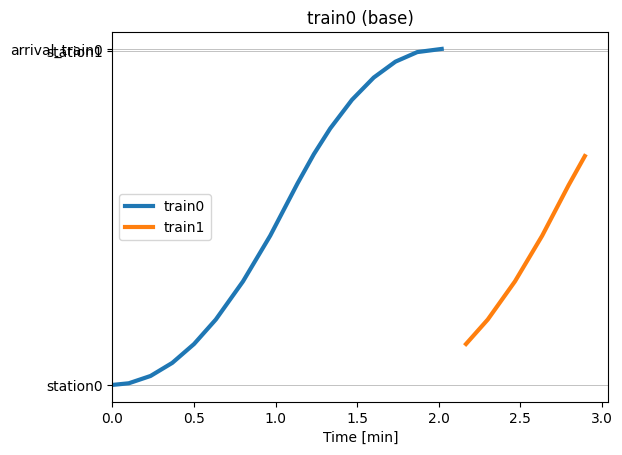

In [253]:
sim.space_time_graph(0)

In [254]:
from rlway.schedule_from_osrd import schedule_from_osrd
from rlway.schedules import Schedule

                            0                       1            
                            s           e           s           e
D0<->buffer_stop.0        0.0   49.271387         NaN         NaN
CVG                 25.290046   53.626722  125.290046  153.626722
D2<->D3             32.871583   96.466092  132.871583  197.099453
D1<->buffer_stop.1        NaN         NaN       100.0  149.271387
DVG                 73.617113  108.066092  173.658637   209.36612
D4<->buffer_stop.2  78.205627  121.066092         NaN         NaN
D5<->buffer_stop.3        NaN         NaN  178.304105  220.699453

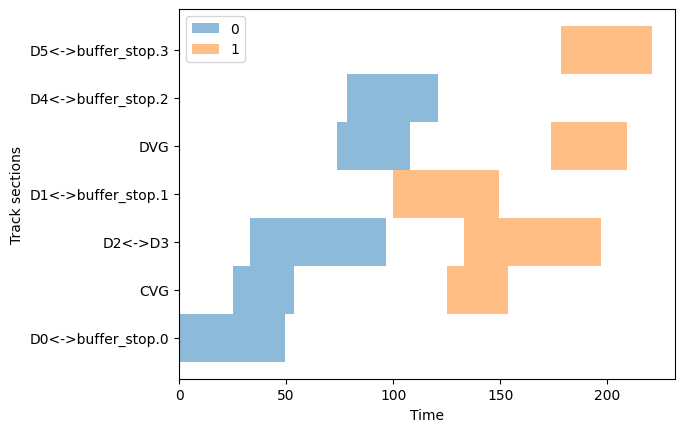

In [255]:
s = Schedule(len(sim.routes), sim.num_trains)
s._df = schedule_df_from_OSRD(sim)
s.plot()
s

In [256]:
s.graph.edges

OutEdgeView([('D0<->buffer_stop.0', 'CVG'), ('CVG', 'D2<->D3'), ('DVG', 'D4<->buffer_stop.2'), ('DVG', 'D5<->buffer_stop.3'), ('D2<->D3', 'DVG'), ('D1<->buffer_stop.1', 'CVG')])

In [257]:
s.is_just_after_a_point_switch(0,1,'DVG')

False

In [258]:
# s.shift_train_after(0,1,'DVG').plot()

In [259]:
["-->".join(list(e)) for e in tvds(sim)]

['buffer_stop.0-->D0',
 'D2-->D0',
 'D3-->D2',
 'D1-->buffer_stop.1',
 'D1-->D2',
 'D3-->D4',
 'buffer_stop.2-->D4',
 'D3-->D5',
 'buffer_stop.3-->D5']

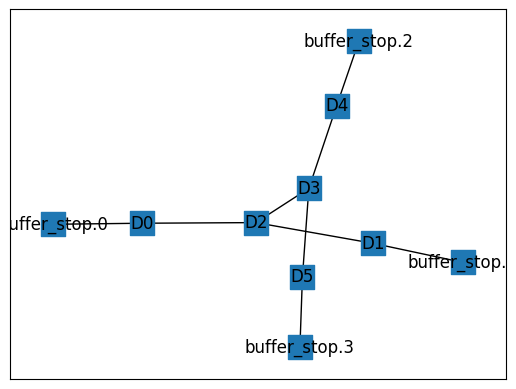

In [260]:
def infra_as_network(self) -> nx.Graph:
    g = nx.Graph()
    [g.add_edge(tuple(e)[0], tuple(e)[1]) for e in tvds(sim)]
    return g

G = infra_as_network(sim)

_, ax = plt.subplots()
nx.draw_networkx(G, node_shape='s', ax=ax)

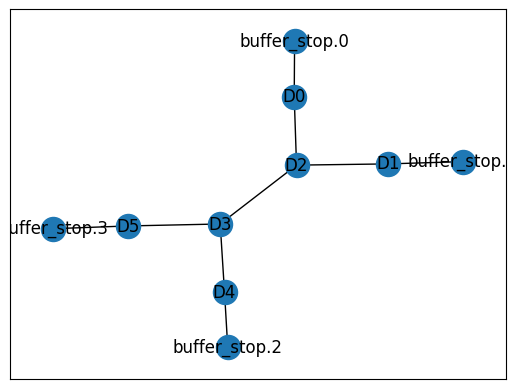

In [261]:
nx.draw_networkx(infra_as_network(sim))

In [270]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))


g = "graph LR;"+";".join(
    [f'{tuple(e)[0]}<--> {tuple(e)[1]}' for e in tvds(sim)]
    )

mm(g)

In [278]:
g = "graph LR;"+";".join([
    f"{edge[0].replace('<','').replace('>','')}-->{edge[1].replace('<','').replace('>','')}"
    for edge in s.graph.edges
])
mm(g)